# Verify GPU Connection

In [2]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Set memory growth to True to allocate memory as needed
            tf.config.experimental.set_memory_growth(gpu, True)
            # Set a memory limit of 10GB (10240MB)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
    except RuntimeError as e:
        print(e)


In [3]:
# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# List all physical devices
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Check if TensorFlow is using the GPU
if gpus:
    print("Number of GPUs available: ", len(gpus))
    for gpu in gpus:
        print("GPU:", gpu)

    # Perform a simple computation on the GPU
    with tf.device('/GPU:0'):
        a = tf.constant(2.0)
        b = tf.constant(3.0)
        c = a * b
        print(f"Result of computation on GPU: {c.numpy()}")
else:
    print("No GPU found")


TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs available:  1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Result of computation on GPU: 6.0


# Get the Data

In [4]:
train_dir = "D:\\Wikiart_splitted\\train"
test_dir = "D:\\Wikiart_splitted\\test"
val_dir= "D:\\Wikiart_splitted\\val"

# Import necessary libraries and modules

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [6]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Model 3_a: SGD Optimiser

# Prepare the data

In [7]:
batch_size = 32
img_height = 224  # Adjusted for DenseNet121
img_width = 224

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

# Define number of classes
num_classes = train_generator.num_classes

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model Building

In [8]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 25 layers
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# Model training

In [9]:
# Define callbacks
checkpoint = ModelCheckpoint('Model3_a.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 2.6923 - accuracy: 0.1640
Epoch 1: val_accuracy improved from -inf to 0.20596, saving model to Model3_a.h5
1899/1899 [==============================] - 1019s 533ms/step - loss: 2.6923 - accuracy: 0.1640 - val_loss: 2.5620 - val_accuracy: 0.2060
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 2.5046 - accuracy: 0.2214
Epoch 2: val_accuracy improved from 0.20596 to 0.24657, saving model to Model3_a.h5
1899/1899 [==============================] - 1007s 530ms/step - loss: 2.5046 - accuracy: 0.2214 - val_loss: 2.4189 - val_accuracy: 0.2466
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 2.3968 - accuracy: 0.2499
Epoch 3: val_accuracy improved from 0.24657 to 0.27057, saving model to Model3_a.h5
1899/1899 [==============================] - 987s 520ms/step - loss: 2.3968 - accuracy: 0.2499 - val_loss: 2.3181 - val_accuracy: 0.2706
Epoch 4/10
1899/1899 [======================

In [13]:
model.save('3_a.h5')

# Evaluate the model

In [10]:
model.load_weights('Model3_a.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 77s 324ms/step - loss: 1.9800 - accuracy: 0.3586
Test accuracy: 0.3586497902870178


# Plot accuracy and loss graphs

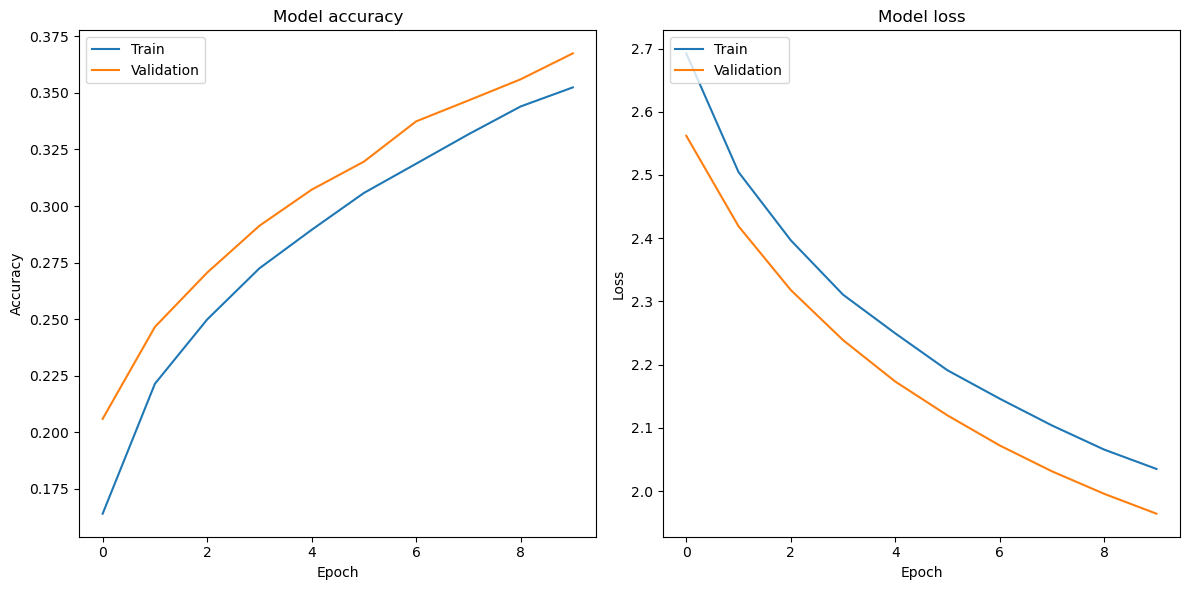

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Plot confusion matrix and classification metrics

Found 7596 images belonging to 19 classes.
238/238 [==============================] - 76s 312ms/step


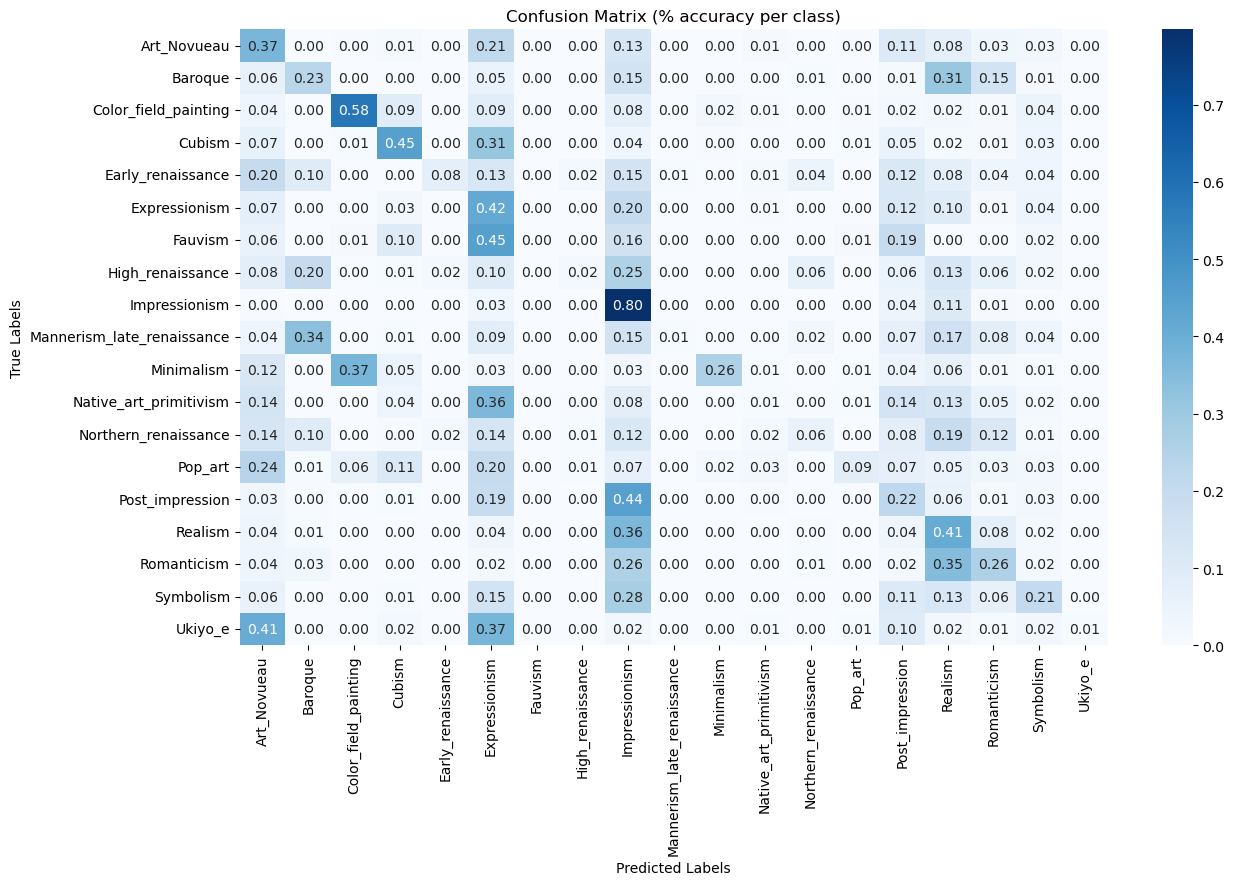

                            precision    recall  f1-score   support

               Art_Novueau       0.25      0.37      0.30       413
                   Baroque       0.40      0.23      0.29       418
      Color_field_painting       0.59      0.58      0.58       182
                    Cubism       0.54      0.45      0.49       261
         Early_renaissance       0.57      0.08      0.13       157
             Expressionism       0.26      0.42      0.32       659
                   Fauvism       0.00      0.00      0.00        89
          High_renaissance       0.20      0.02      0.03       126
             Impressionism       0.42      0.80      0.55      1314
Mannerism_late_renaissance       0.25      0.01      0.01       137
                Minimalism       0.76      0.26      0.39       147
    Native_art_primitivism       0.06      0.01      0.01       278
      Northern_renaissance       0.29      0.06      0.10       240
                   Pop_art       0.54      0.09

In [2]:
# Path to saved model
model_path = 'C:\\Users\\PRANAV\\Downloads\\Model3_a.h5'
model = load_model(model_path)

test_data_directory = "D:\\Wikiart_splitted\\test"

batch_size = 32
image_height = 299
image_width = 299

# ImageDataGenerator for preprocessing and loading test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(image_height, image_width), 
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels from the generator

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (% accuracy per class)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Model 3_b: Adam, BN, Dropout

# Prepare the data

In [7]:
batch_size = 32
img_height = 224  # Adjusted for DenseNet121
img_width = 224

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

# Define number of classes
num_classes = train_generator.num_classes

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model building

In [8]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 25 layers
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# Model training

In [9]:
# Define callbacks
checkpoint = ModelCheckpoint('Model3_b.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 2.0478 - accuracy: 0.3635
Epoch 1: val_accuracy improved from -inf to 0.50040, saving model to Model3_b.h5
1899/1899 [==============================] - 1046s 548ms/step - loss: 2.0478 - accuracy: 0.3635 - val_loss: 1.4804 - val_accuracy: 0.5004
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 1.6258 - accuracy: 0.4622
Epoch 2: val_accuracy improved from 0.50040 to 0.53191, saving model to Model3_b.h5
1899/1899 [==============================] - 1019s 537ms/step - loss: 1.6258 - accuracy: 0.4622 - val_loss: 1.3940 - val_accuracy: 0.5319
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 1.4639 - accuracy: 0.5078
Epoch 3: val_accuracy improved from 0.53191 to 0.55063, saving model to Model3_b.h5
1899/1899 [==============================] - 1021s 538ms/step - loss: 1.4639 - accuracy: 0.5078 - val_loss: 1.3175 - val_accuracy: 0.5506
Epoch 4/10
1899/1899 [=====================

In [10]:
model.save('3_b.h5')

# Evaluate the model

In [11]:
model.load_weights('Model3_b.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 76s 320ms/step - loss: 1.2306 - accuracy: 0.5902
Test accuracy: 0.5901898741722107


# Plot accuracy and loss graphs

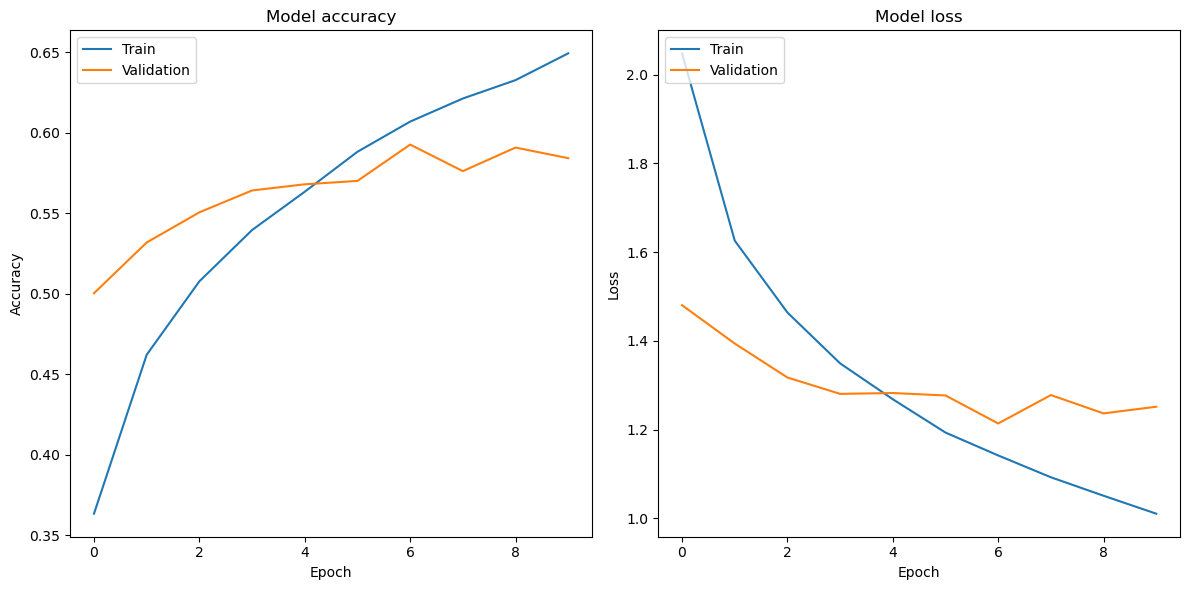

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# Plot confusion matrix and classification metrics

Found 7596 images belonging to 19 classes.
238/238 [==============================] - 76s 313ms/step


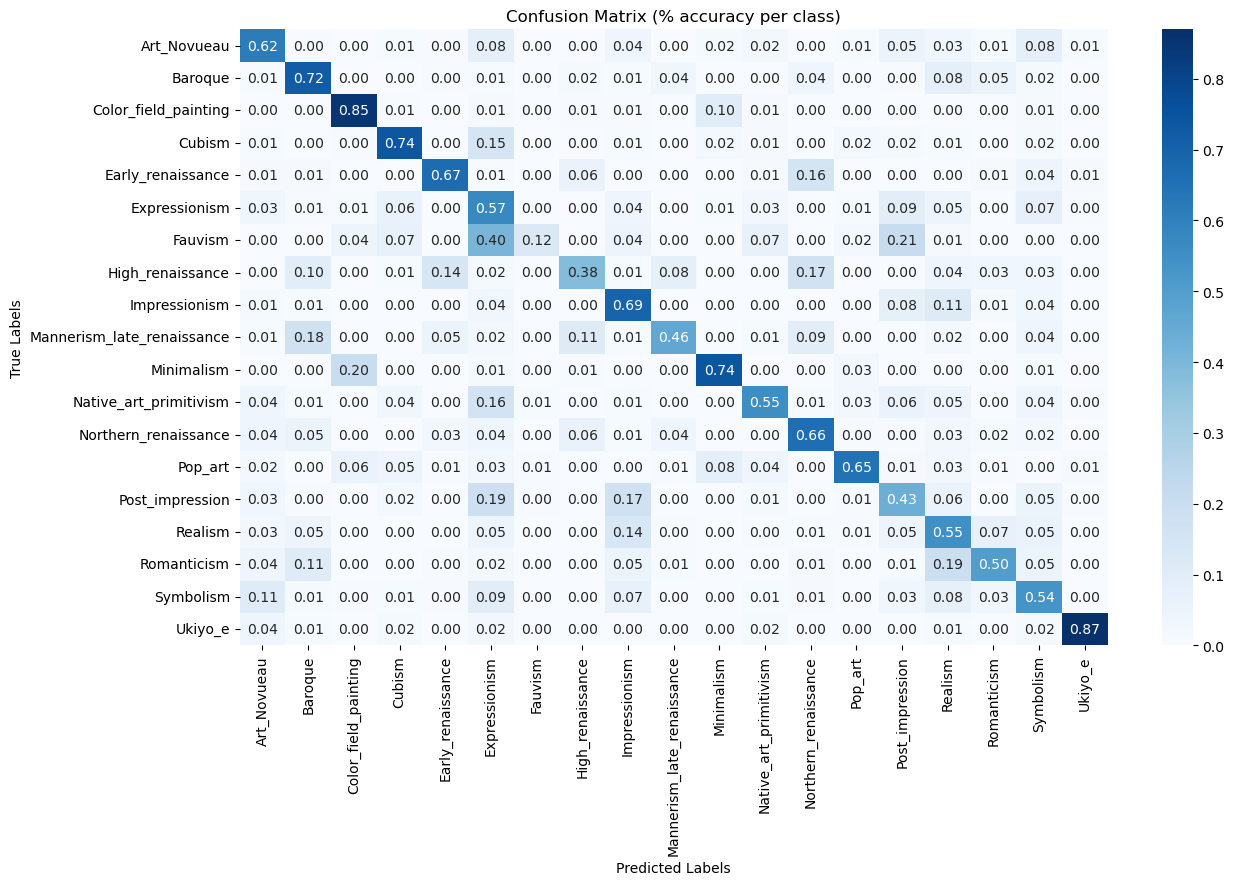

                            precision    recall  f1-score   support

               Art_Novueau       0.56      0.62      0.58       413
                   Baroque       0.60      0.72      0.65       418
      Color_field_painting       0.73      0.85      0.79       182
                    Cubism       0.68      0.74      0.71       261
         Early_renaissance       0.70      0.67      0.68       157
             Expressionism       0.45      0.57      0.51       659
                   Fauvism       0.55      0.12      0.20        89
          High_renaissance       0.48      0.38      0.42       126
             Impressionism       0.70      0.69      0.70      1314
Mannerism_late_renaissance       0.57      0.46      0.51       137
                Minimalism       0.67      0.74      0.70       147
    Native_art_primitivism       0.69      0.55      0.61       278
      Northern_renaissance       0.60      0.66      0.63       240
                   Pop_art       0.69      0.65

In [3]:
# Path to saved model
model_path = 'C:\\Users\\PRANAV\\Downloads\\Model3_b.h5'
model = load_model(model_path)


test_data_directory = "D:\\Wikiart_splitted\\test"

batch_size = 32
image_height = 299
image_width = 299

# ImageDataGenerator for preprocessing and loading test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(image_height, image_width), 
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels from the generator

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (% accuracy per class)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Model 3_c

# Prepare the data

In [16]:
batch_size = 16
img_height = 224  # Adjusted for DenseNet121
img_width = 224

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

# Define number of classes
num_classes = train_generator.num_classes

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model building

In [17]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last 25 layers
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

# Model training

In [18]:
# Define callbacks
checkpoint = ModelCheckpoint('Model3_c.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
3798/3798 [==============================] - ETA: 0s - loss: 2.0181 - accuracy: 0.3664
Epoch 1: val_accuracy improved from -inf to 0.50026, saving model to Model3_c.h5
3798/3798 [==============================] - 1007s 264ms/step - loss: 2.0181 - accuracy: 0.3664 - val_loss: 1.5041 - val_accuracy: 0.5003
Epoch 2/10
3798/3798 [==============================] - ETA: 0s - loss: 1.6211 - accuracy: 0.4623
Epoch 2: val_accuracy improved from 0.50026 to 0.52598, saving model to Model3_c.h5
3798/3798 [==============================] - 1024s 270ms/step - loss: 1.6211 - accuracy: 0.4623 - val_loss: 1.4091 - val_accuracy: 0.5260
Epoch 3/10
3798/3798 [==============================] - ETA: 0s - loss: 1.4637 - accuracy: 0.5053
Epoch 3: val_accuracy improved from 0.52598 to 0.55934, saving model to Model3_c.h5
3798/3798 [==============================] - 998s 263ms/step - loss: 1.4637 - accuracy: 0.5053 - val_loss: 1.2947 - val_accuracy: 0.5593
Epoch 4/10
3798/3798 [======================

In [19]:
model.save('3_c.h5')

# Evaluate the model

In [20]:
model.load_weights('Model3_c.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


474/474 [==============================] - 79s 166ms/step - loss: 1.2270 - accuracy: 0.5906
Test accuracy: 0.590585470199585


# Plot accuracy and loss graphs

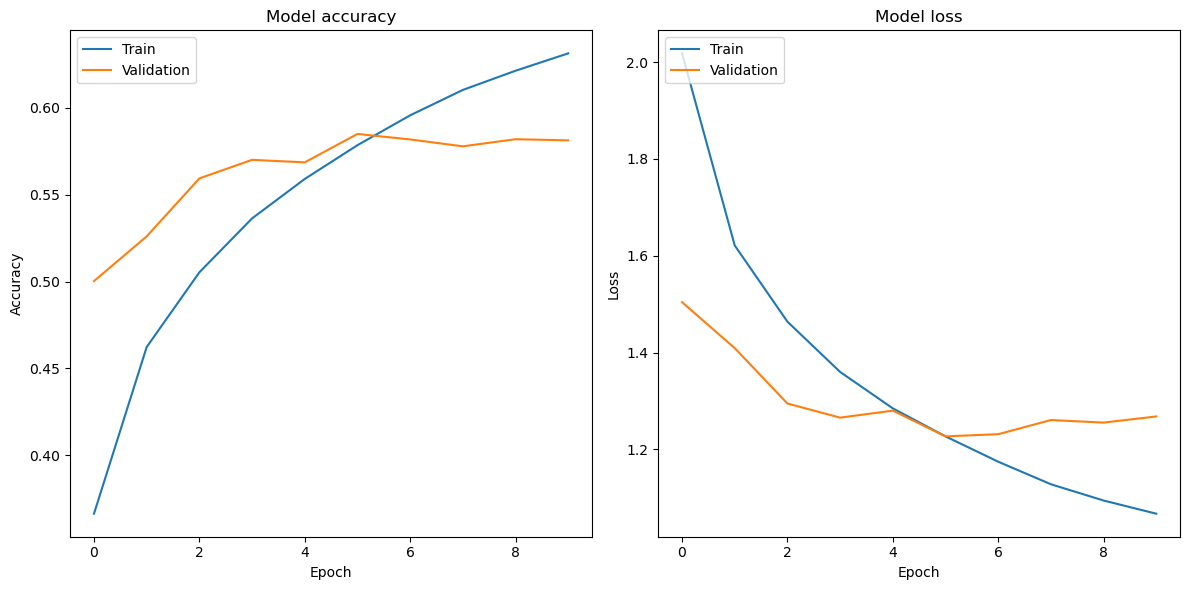

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# Plot confsuion matrix and classification metrics

Found 7596 images belonging to 19 classes.
238/238 [==============================] - 79s 328ms/step


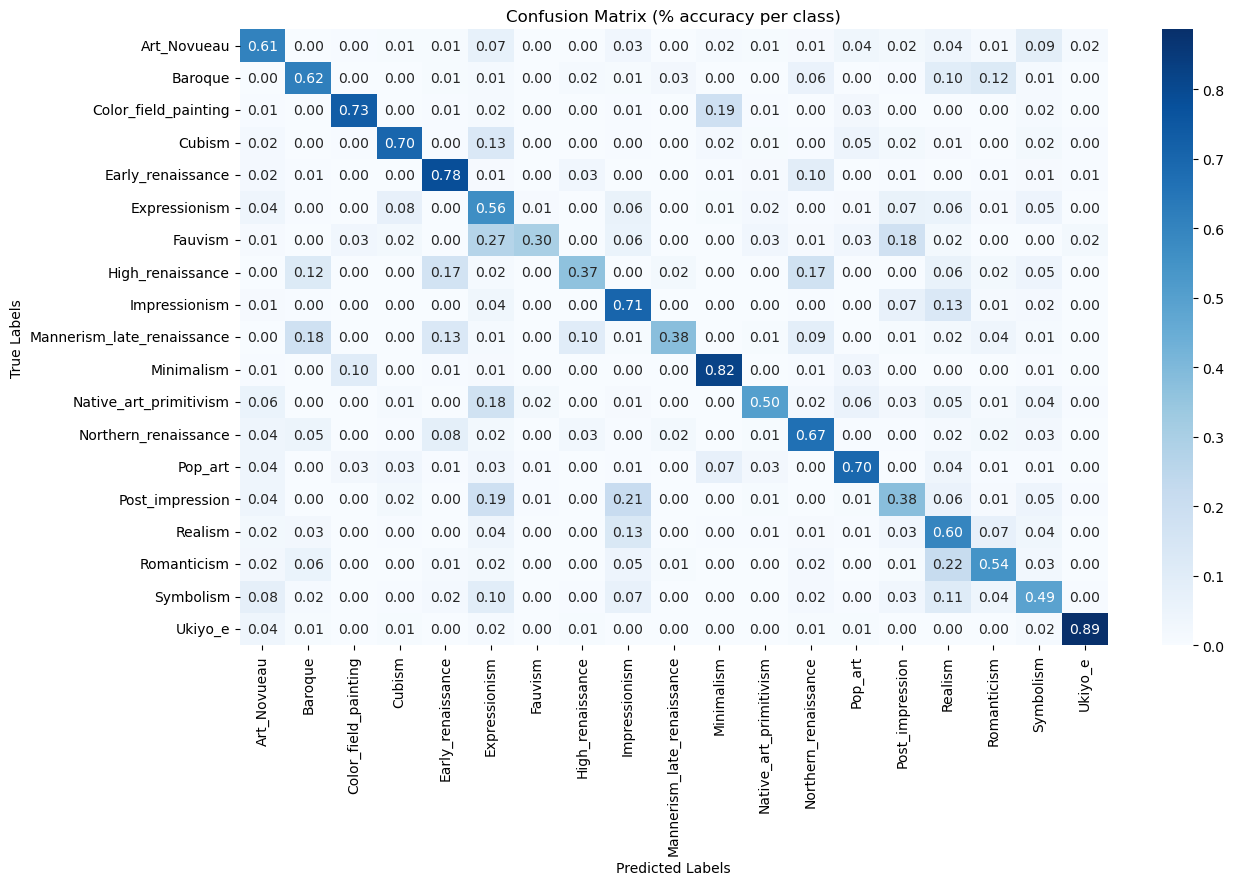

                            precision    recall  f1-score   support

               Art_Novueau       0.56      0.61      0.58       413
                   Baroque       0.65      0.62      0.63       418
      Color_field_painting       0.83      0.73      0.78       182
                    Cubism       0.67      0.70      0.68       261
         Early_renaissance       0.57      0.78      0.66       157
             Expressionism       0.46      0.56      0.51       659
                   Fauvism       0.53      0.30      0.39        89
          High_renaissance       0.53      0.37      0.43       126
             Impressionism       0.69      0.71      0.70      1314
Mannerism_late_renaissance       0.65      0.38      0.48       137
                Minimalism       0.63      0.82      0.71       147
    Native_art_primitivism       0.76      0.50      0.61       278
      Northern_renaissance       0.55      0.67      0.60       240
                   Pop_art       0.56      0.70

In [4]:
# Path to saved model
model_path = 'C:\\Users\\PRANAV\\Downloads\\Model3_c.h5'
model = load_model(model_path)


test_data_directory = "D:\\Wikiart_splitted\\test"

batch_size = 32
image_height = 299
image_width = 299

# ImageDataGenerator for preprocessing and loading test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(image_height, image_width), 
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

# Make predictions
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels from the generator

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (% accuracy per class)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))